# Analiza danych emg

In [2]:
import sys

sys.path.append("..")

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.pyplot import subplot
from matplotlib.pyplot import figure
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
plt.style.use("seaborn-ticks")
%matplotlib inline
from pyomeca import Analogs

from ezc3d import c3d

In [3]:
data_path = "../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T01.c3d"
data_path2 = "../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T02.c3d"

#### Wczytanie danych analogowych i przydzielenie odpowiednich nazw

In [4]:
muscles_names = [
    "Czworoboczny grzbietu L",
    "Trójgłowy ramienia L", 
    "Dwugłowy ramienia L", 
    "Prostownik nadgarstka L",
    "Skośny brzucha L", 
    "Pośladkowy średni L",
    "Czworogłowy uda L", 
    "Brzuchaty łydki L",
    "Czworoboczny grzbietu P",
    "Trójgłowy ramienia P", 
    "Dwugłowy ramienia P", 
    "Prostownik nadgarstka P",
    "Skośny brzucha P", 
    "Pośladkowy średni P",
    "Czworogłowy uda P", 
    "Brzuchaty łydki P"]

def read_analogs(data_path):
    muscles = [
    "Voltage.1",
    "Voltage.2",
    "Voltage.3",
    "Voltage.4",
    "Voltage.5",
    "Voltage.6",
    "Voltage.7",
    "Voltage.8",
    "Voltage.9",
    "Voltage.10",
    "Voltage.11",
    "Voltage.12",
    "Voltage.13",
    "Voltage.14",
    "Voltage.15",
    "Voltage.16"]
    
    emg = Analogs.from_c3d(data_path, usecols=muscles)
    
    emg['channel']=muscles_names
    return emg

#### Wyświetlanie danych na wykresie

In [5]:
def show_emg_data(data_to_show):
    data_to_show.plot(x="time", col="channel", col_wrap=3)

#### Normalizacja danych

In [6]:
def normalize_data(data_path):
    emg_p = (
        data_path.meca.band_pass(order=2, cutoff=[10, 425])
        .meca.center()
        .meca.abs()
        .meca.low_pass(order=4, cutoff=5, freq=data_path.rate)
        .meca.normalize(ref=None, scale=1)
    ) 
    emg_p.name = "EMG"
    emg_p.attrs["units"] = "%"
    emg_p.time.attrs["units"] = "seconds"
    return emg_p

#### Odczytanie oznaczonych event'ów z pliku

In [7]:
def read_events(data_path):
    c3d_to_compare= c3d(data_path)
    event_time = c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]
    
    return event_time

#### Dane z pliku .c3d (przed normalizacją):

In [8]:
readed_emg = read_analogs(data_path)
readed_emg2 = read_analogs(data_path2)
#show_emg_data(readed_emg)
#show_emg_data(readed_emg2)

#### Dane po normalizacji:

In [9]:
emg_processed = normalize_data(readed_emg)
emg_processed2 = normalize_data(readed_emg2)
#show_emg_data(emg_processed)
#show_emg_data(emg_processed2)

#### Odczytanie czasu event'ów:

In [10]:
event_time = read_events(data_path)
event_time

array([10.90999985, 12.25      , 12.26000023, 15.07999992, 16.18000031,
       19.12999916, 19.30999947, 24.03000069, 24.88999939, 30.46999931,
       31.13999939, 35.74000168, 37.15000153, 43.52999878])

In [11]:
event_time2 = read_events(data_path2)
event_time2

array([ 9.18999958, 11.18999958, 11.19999981, 15.15999985, 18.86000061,
       20.36000061, 21.42000008, 24.14999962, 39.22000122, 42.49000168,
       51.83000183, 55.97000122,  2.41000009,  6.38000011])

In [12]:
event_time2[12] = 62.41000009
event_time2[13] = 66.38000011
event_time2

array([ 9.18999958, 11.18999958, 11.19999981, 15.15999985, 18.86000061,
       20.36000061, 21.42000008, 24.14999962, 39.22000122, 42.49000168,
       51.83000183, 55.97000122, 62.41000009, 66.38000011])

In [13]:
def compare_events_average(path, emg_processed, event_time):
         
    aver_arr_all=np.zeros((16,1000))
    
    for file in glob.glob(path,recursive = True):
        print(file)

        aver_arr=np.zeros((16,1000))  
        file_num=0

        for num in range(16):

            emg_processed_event=emg_processed[num]
            emg_processed_event2 = (
            emg_processed_event.meca.normalize(ref=None, scale=1)                
            )
            time_normalized=emg_processed_event2.meca.time_normalize(n_frames=1000)
            
            c3d_to_compare= c3d(file)
            n_frames = c3d_to_compare['parameters']['POINT']['FRAMES']['value'][0]
            nn = n_frames/1000
            markevent = event_time/nn*100

            for t in range(1000):
                aver_arr[num][t]=aver_arr[num][t]+time_normalized.values[t]

            aver_arr[num]=aver_arr[num]/10

            for t2 in range(1000):
                aver_arr_all[file_num][t2]=aver_arr_all[file_num][t2]+time_normalized.values[t2]
            file_num=file_num+1;
        
    return aver_arr_all, markevent

In [14]:
aver_arr1, get_markevent1 = compare_events_average(data_path, emg_processed, event_time)
aver_arr2, get_markevent2 = compare_events_average(data_path2, emg_processed2, event_time2)

../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T01.c3d
../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T02.c3d


In [15]:
def plot_compare_events_average(path, aver_arr_all, event_time, markevent):
        
    for file in glob.glob(path,recursive = True):
        print(file)
    
        for num in range(16):
        
            subplot(1, 2, 1)
            plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=5, 
                        top=0.25, 
                        wspace=0.25, 
                        hspace=0.35)
            time=np.linspace(1,1000,1000)
            #aver_arr_all[num]=aver_arr_all[num]/5
            plt.plot(time,aver_arr_all[num])
            axl = 0
            for axl in range(14):
                plt.axvline(markevent[axl], color='r')
            plt.title(muscles_names[num])
            plt.axhline(0.25, color='k', linestyle='--')
            plt.fill_between(time,aver_arr_all[num])
            plt.show()

../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T01.c3d


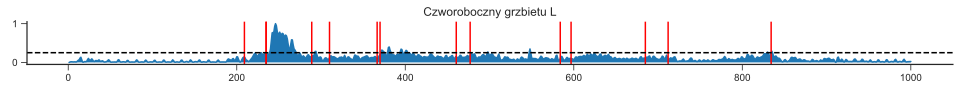

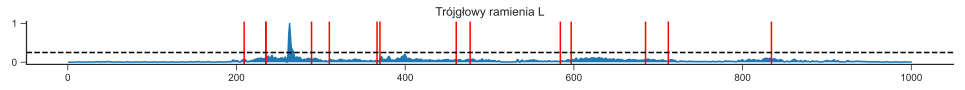

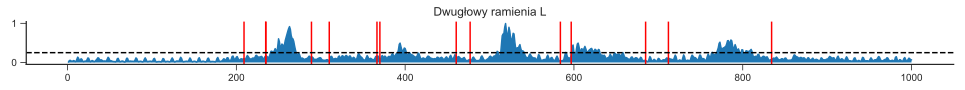

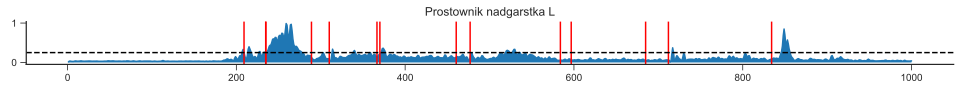

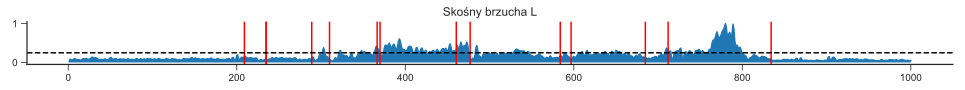

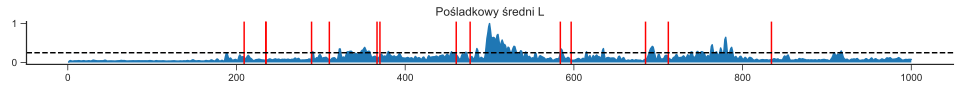

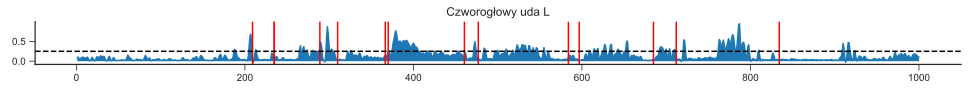

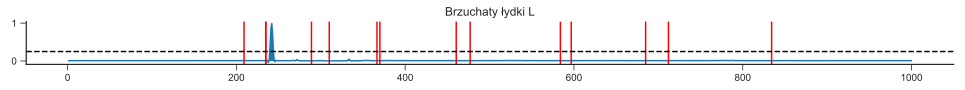

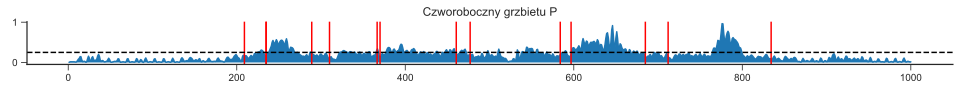

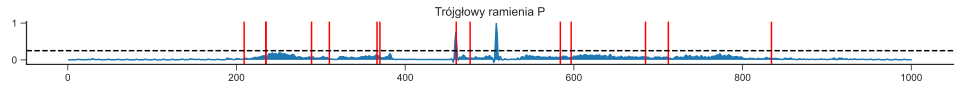

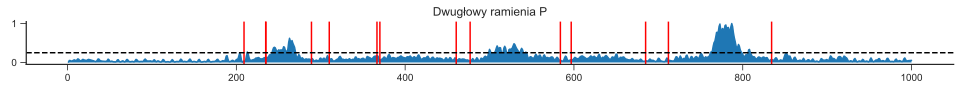

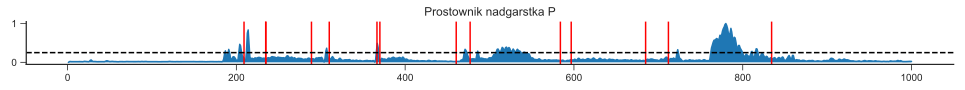

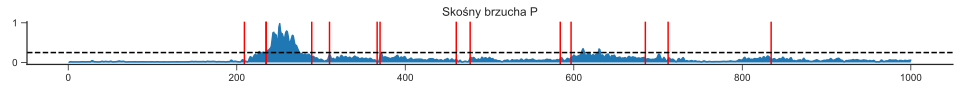

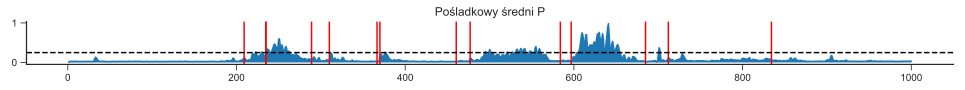

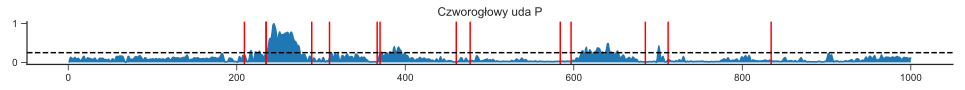

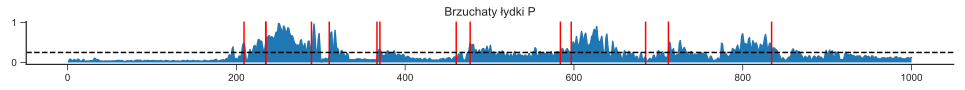

../Jupyter/c3d/B0437 PrzenoszeniePrawidlowe T02.c3d


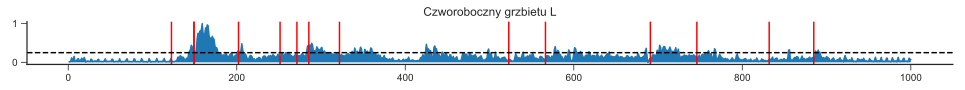

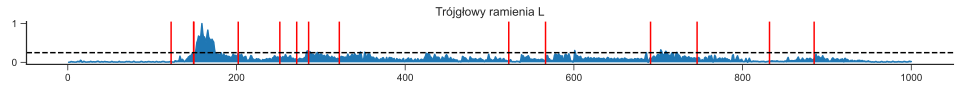

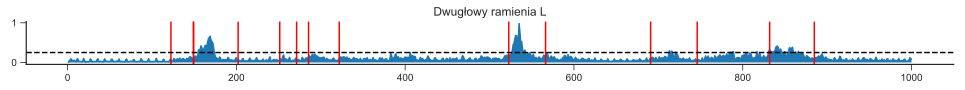

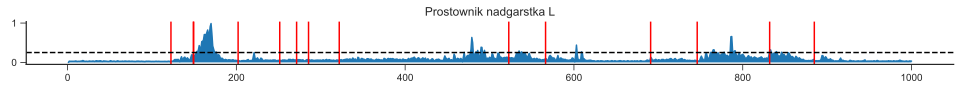

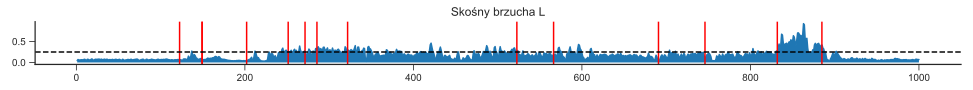

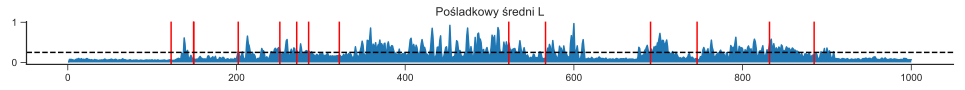

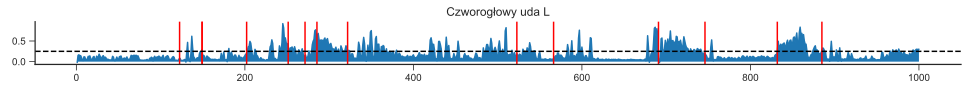

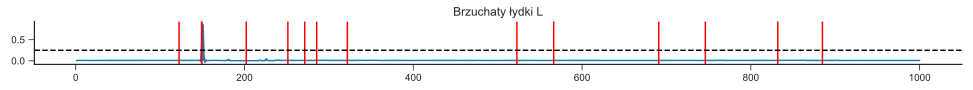

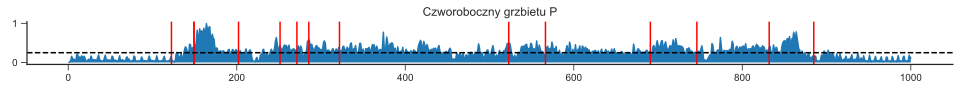

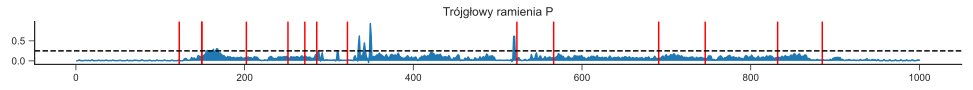

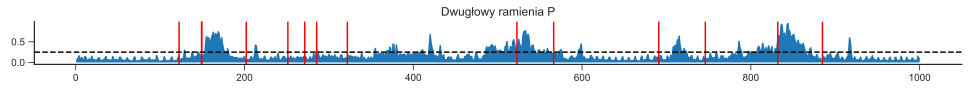

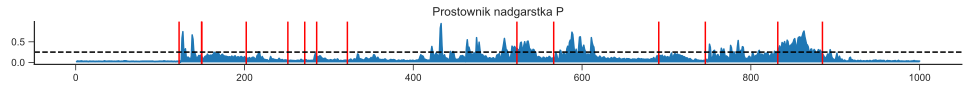

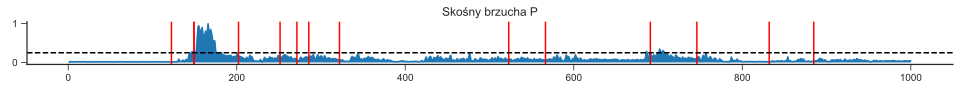

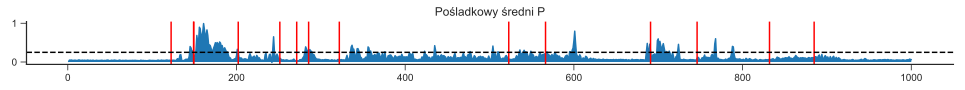

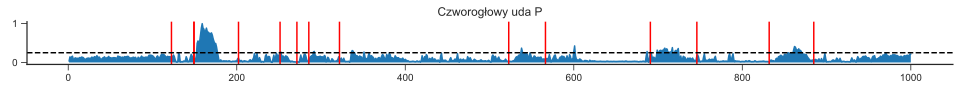

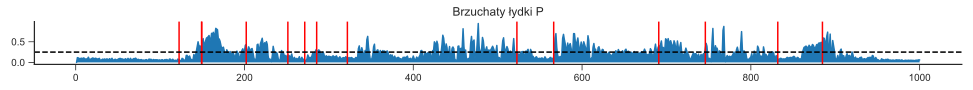

In [16]:
plot_compare_events_average(data_path, aver_arr1, event_time, get_markevent1)
plot_compare_events_average(data_path2, aver_arr2, event_time2, get_markevent2)

In [17]:
def plot_all():
    time=np.linspace(1,1000,1000)
    aver_arr_all=np.zeros((16,1000))

    for num in range(16):
        subplot(1, 2, 1)
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=5, 
                    top=0.5, 
                    wspace=0.25, 
                    hspace=0.35)
        #aver_arr_all[num]=aver_arr_all[num]/2
        plt.plot(time,aver_arr1[num], label = "B0437 PrzenoszeniePrawidlowe T01")
        plt.plot(time,aver_arr2[num], label = "B0437 PrzenoszeniePrawidlowe T02")
        plt.title(muscles_names[num])
        plt.legend(loc='right', borderaxespad=-5) 
        plt.show()

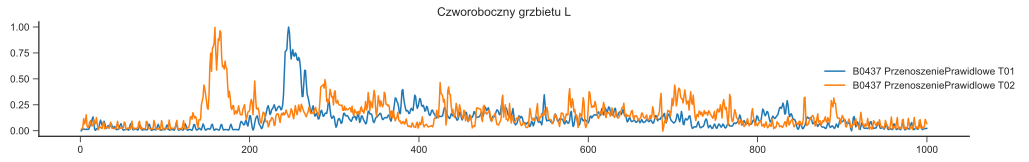

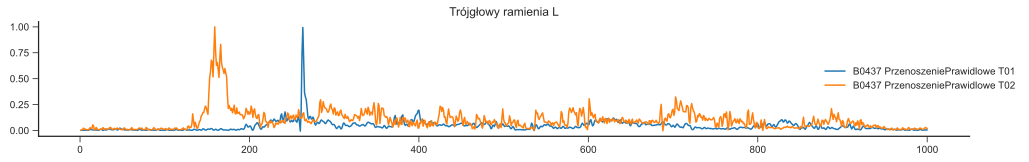

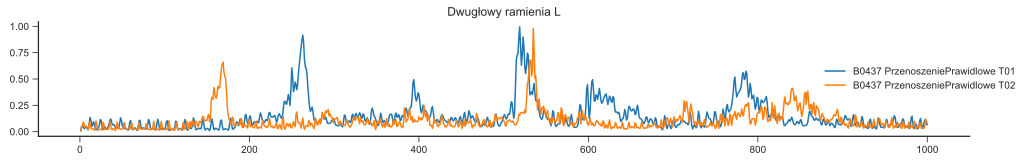

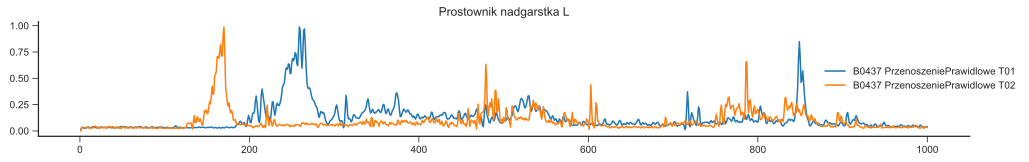

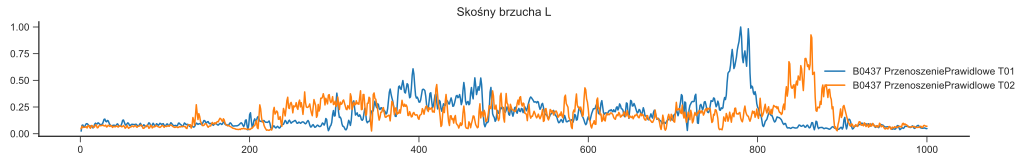

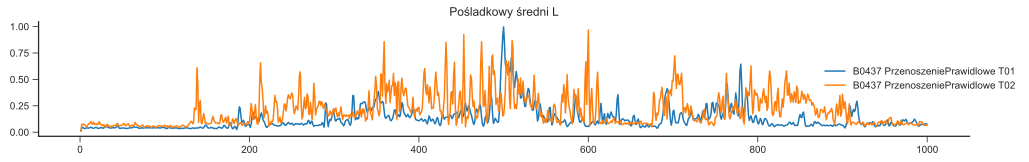

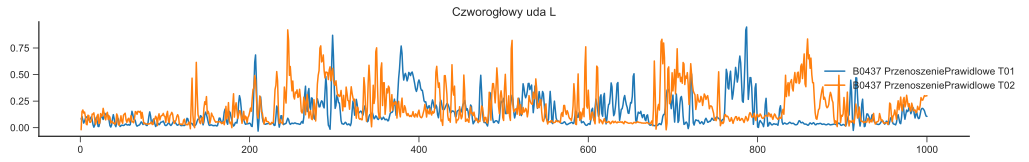

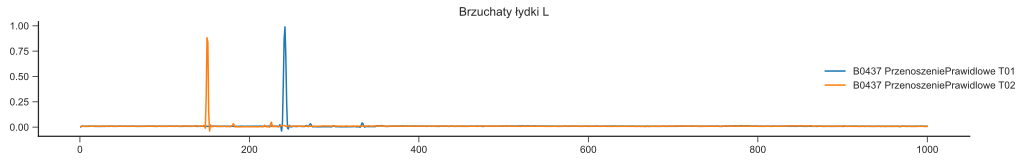

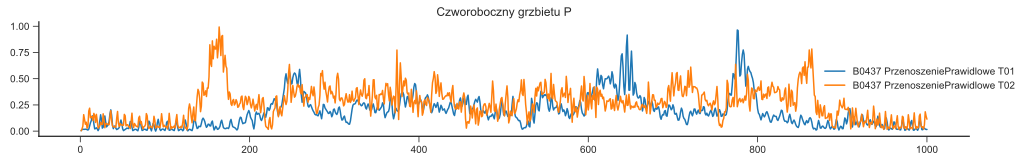

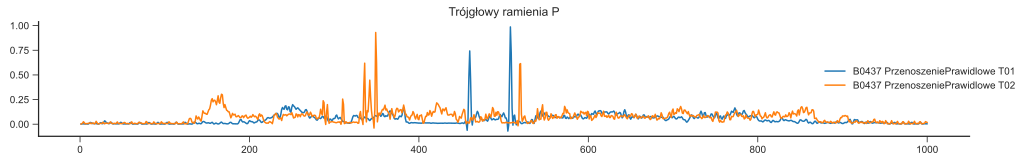

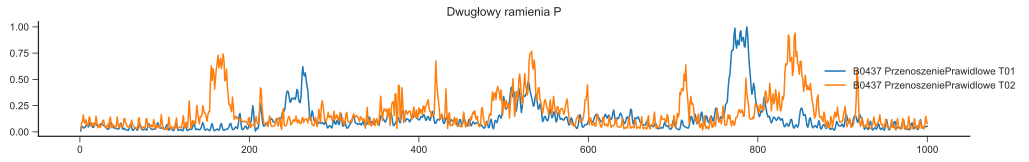

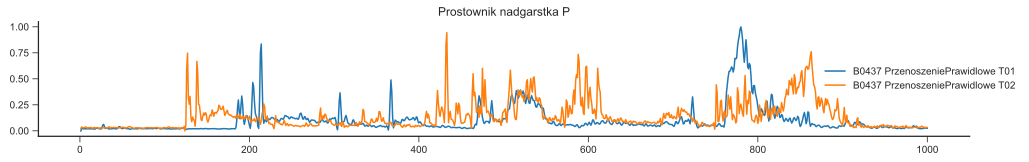

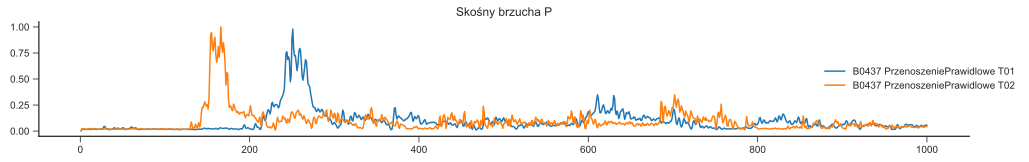

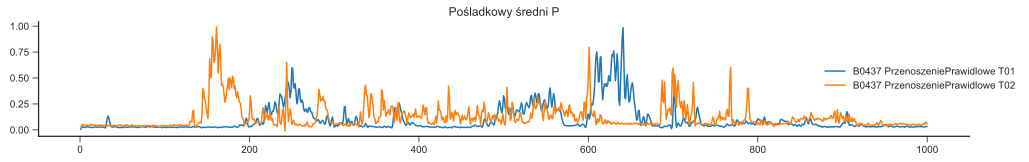

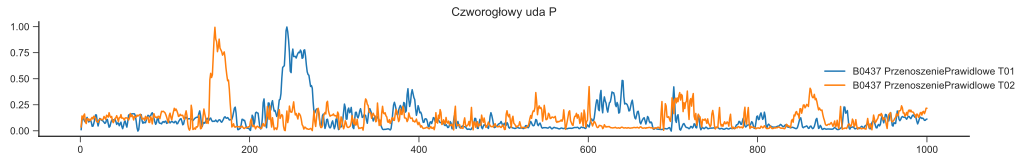

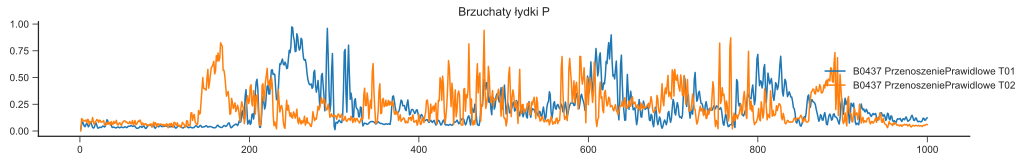

In [18]:
plot_all()

In [2]:
def plot_one_event(aver_arr, markevent, label, index1, index2):
    
    print(label)
    if (index1 == 0):
        print("Wyciągnięcie do pacjenta")
    if (index1 == 2):
        print("Ugięcie nóg pacjenta")
    if (index1 == 4):
        print("Ułożenie prawej ręki pacjenta")
    if (index1 == 6):
        print("Ułożenie lewej ręki pacjenta")
    if (index1 == 8):
        print("Przewrócenie pacjenta")
    if (index1 == 10):
        print("Opuszczenie nóg pacjenta")
    if (index1 == 12):
        print("Posadzenie pacjenta")

    for num in range(16):
            time = np.linspace(1,1000,1000)
            subplot(1, 2, 1)
            plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=5, 
                            top=0.5, 
                            wspace=0.25, 
                            hspace=0.35)
            plt.plot(time,aver_arr[num])
            plt.xlim(markevent[index1], markevent[index2])
            plt.axhline(0.25, color='k', linestyle='--')
            plt.title(muscles_names[num])
            plt.show()